## Sliding window

Here we fit the entire Cygnus region using 10 overlappig rectangular sub-regions.
The results are stored in a JSON file. You can both use a Gaussian and a "HESS-like" spatial model.

In [11]:
from gammapy.maps import Map
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ConstantSpectralModel,
    SkyModel,
    DiskSpatialModel,
    GeneralizedGaussianSpatialModel,
    GaussianSpatialModel,
    Models,
)
from gammapy.analysis import Analysis, AnalysisConfig

from modules import write_json, read_json, plot_results

import os
import glob
import shutil
import json
import time
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Configuration parameters

In [12]:
config = AnalysisConfig()
config.observations.datastore = ("../")
config.observations.obs_cone.frame = "galactic"
config.observations.obs_cone.lat = "2 deg"
config.observations.obs_cone.radius = "5 deg"

config.datasets.type = "3d"
config.datasets.stack = True
config.datasets.geom.wcs.width = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.1 deg"
config.datasets.geom.axes.energy.max = "20 TeV"
config.datasets.geom.axes.energy.nbins = 5
config.datasets.geom.axes.energy.min = "0.7 TeV"
config.datasets.geom.axes.energy_true.min = "0.1 TeV"
config.datasets.geom.axes.energy_true.max = "20 TeV"
config.datasets.geom.axes.energy_true.nbins = 5
config.datasets.background.parameters = {"method": "scale"}
config.datasets.background.method = "fov_background"
config.fit.fit_range.min = 0.7 * u.TeV
config.fit.fit_range.max = 10 * u.TeV
config.flux_points.energy = {"min": "0.7 TeV", "max": "100 TeV", "nbins": 10}
config.excess_map.correlation_radius = 0.1 * u.deg

In [13]:
# Spatial and spectral models
spectra = 1
spatial = 1

if spectra == 0:
    spectral_model = ConstantSpectralModel(const="1e1 / (cm2 s TeV)")
else:
    spectral_model = PowerLawSpectralModel(
        index=2,
        amplitude="1e-12 TeV-1 cm-2 s-1",
        reference=1 * u.TeV,
    )

if spatial == 0:
    spatial_model = GaussianSpatialModel(
        lon_0=0 * u.deg,
        lat_0=1.5 * u.deg,
        sigma="1 deg",
        e=0.01,
        phi=0 * u.deg,
        frame="galactic",
    )
elif spatial == 1:
    spatial_model = DiskSpatialModel(
        lon_0=0 * u.deg,
        lat_0=1.5 * u.deg,
        r_0="1 deg",
        e=0.01,
        phi=0 * u.deg,
        edge_width=0.1,
        frame="galactic",
    )
else:
    spatial_model = GeneralizedGaussianSpatialModel(
        lon_0=0 * u.deg,
        lat_0=1.5 * u.deg,
        eta=.5,
        r_0=12 * u.deg,
        e=.999,
        phi=90 * u.deg,
        frame="galactic",
    )


### Start of the loop

In [14]:
# Create JSON file
with open(f"results_sliding_window.json", "w") as outfile:
    json.dump({}, outfile)

# Here you can change the "steps" of the sliding window
for i in np.arange(68, 79, 0.5):
    config.datasets.geom.wcs.skydir = {
        "lon": f"{i} deg",
        "lat": "2.0 deg",
        "frame": "galactic",
    }
    config.observations.obs_cone.lon = f"{i} deg"

    analysis = Analysis(config)
    analysis.get_observations()
    analysis.get_datasets()

    mask_map = Map.read("exclusion_mask.fits")
    mask_map.data = mask_map.data.astype(bool)
    analysis.datasets["stacked"].mask_fit = mask_map

    model_config = SkyModel(spectral_model=spectral_model,
                            spatial_model=spatial_model, name="cygnus_background")

    model_config = Models([model_config])
    model_sim = model_config.copy()

    analysis.set_models(model_config, extend=False)
    analysis.models[0].parameters["lon_0"].frozen = True
    analysis.models[0].parameters["lon_0"].value = i
    analysis.models[0].parameters["lat_0"].max = 5
    analysis.models[0].parameters["lat_0"].min = -4
    if spectra == 1:
        analysis.models[0].parameters["amplitude"].max = 1.e-11
        analysis.models[0].parameters["amplitude"].min = 1.e-14
    if spatial == 1:
        analysis.models[0].parameters["r_0"].max = 5
        analysis.models[0].parameters["r_0"].min = 0
        analysis.models[0].parameters["e"].frozen = False
        analysis.models[0].parameters["phi"].frozen = True
        analysis.models[0].parameters["edge_width"].frozen = True
    if spatial != 0 and spatial != 1:
        analysis.models[0].parameters["r_0"].frozen = True
    analysis.models[1].parameters["norm"].frozen = False
    analysis.models[1].parameters["norm"].value = 1

    analysis.run_fit()

    results = {
        str(analysis.fit_result.parameters["lon_0"].value): {
            "models": [analysis.models[0].spectral_model.tag[0], analysis.models[0].spatial_model.tag[0]],
            "result": [analysis.fit_result.optimize_result.success,
                       analysis.fit_result.optimize_result.message,
                       analysis.fit_result.optimize_result.total_stat],
            analysis.models[0].spectral_model.parameters[spectra].name: analysis.models[0].spectral_model.parameters[spectra].value,
        },
    }
    for i in range(1, 5):
        results[str(analysis.fit_result.parameters["lon_0"].value)] |= {
            analysis.models[0].spatial_model.parameters[i].name: analysis.models[0].spatial_model.parameters[i].value
        }
    if spatial != 0:
        results[str(analysis.fit_result.parameters["lon_0"].value)] |= {
            analysis.models[0].spatial_model.parameters[5].name: analysis.models[0].spatial_model.parameters[5].value,
        }

    write_json(results, "results_sliding_window.json")

#Save the last config file to save the analysis parameters
config.write("config_sliding_window.yaml", overwrite=True)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 55 out of 55.
Number of selected observations: 55
Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Computing dataset for observation 3
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 3
No default lower safe energy threshold defined for obs 3
Running FoVBackgroundMaker
Computing dataset for observation 120
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 120
No default lower safe energy threshold defined for obs 120
Running FoVBackgroundMaker
Computing dataset for observation 147
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 147
No default lower safe energy threshold defined for obs 147
Running FoVBackgroundMaker
Computing d

### Saving the results in a dedicated folder

In [15]:
timestr = time.strftime("%Y%m%d-%H%M%S")
os.makedirs(f"{timestr}", exist_ok = True)

files = glob.glob(f"*_sliding_window*")
for file in files:
    # extract file name form file path
    file_name = os.path.basename(file)
    shutil.move(file, f"{timestr}/" + file_name)
    print('Moved:', file)

Moved: config_sliding_window.yaml
Moved: results_sliding_window.json


### Checking the results

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

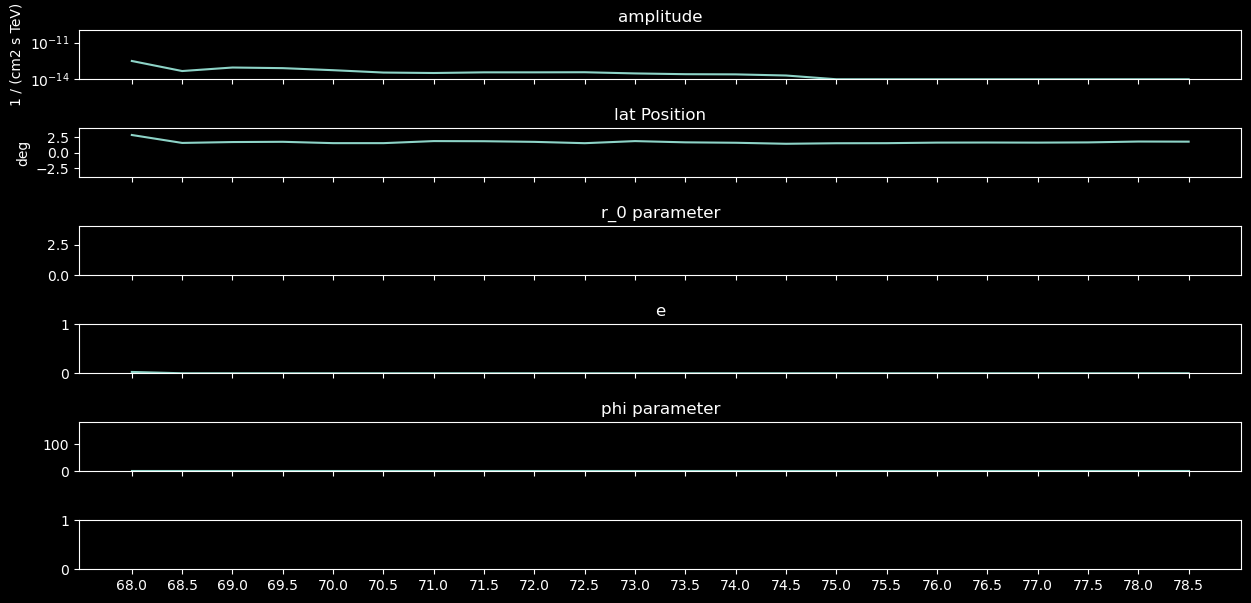

In [16]:
lists = read_json(f"{timestr}/results_sliding_window.json")
plot_results(lists, spectra, spatial)